# Import necessary libraries

In [1]:
from saltup.ai.classification.datagenerator import ClassificationDataloader, keras_ClassificationDataGenerator, pytorch_ClassificationDataGenerator
from saltup.ai.base_dataformat.base_datagen import *
from saltup.ai.object_detection.utils.metrics import Metric
from saltup.ai.training.callbacks import BaseCallback, CallbackContext
from saltup.ai.training.app_callbacks import ClassificationEvaluationsCallback
from saltup.ai.nn_model import NeuralNetworkModel
from saltup.ai.classification.evaluate import evaluate_model
from saltup.utils.jupyter_notebook import generate_notebook_id
from saltup.ai.training.train import training
from saltup.utils.data.image.image_utils import Image, ColorMode


import os
import zipfile
import numpy as np
from glob import glob
from datetime import datetime
import tensorflow as tf

/home/mark/anaconda3/envs/testlib/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2025-07-04 10:15:44.821414: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-04 10:15:44.850591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751616944.885048   42478 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has alr

In [2]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O cats_and_dogs.zip


# Unzip the file using Python
with zipfile.ZipFile("cats_and_dogs.zip", "r") as zip_ref:
    extract_dir = "dataset"
    if not os.path.exists(extract_dir):
        os.makedirs(extract_dir)
    zip_ref.extractall(extract_dir)
    
    os.remove("cats_and_dogs.zip")

--2025-07-04 10:15:53--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.180.187, 142.251.209.27, 142.251.209.59, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.180.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs.zip’

cats_and_dogs.zip   100%[===================>]  65,43M  25,3MB/s    in 2,6s    

2025-07-04 10:15:56 (25,3 MB/s) - ‘cats_and_dogs.zip’ saved [68606236/68606236]



# Define constants

In [3]:
NUM_CLASSES = 2
BATCH_SIZE = 32
EPOCHS = 3
INPUT_SIZE = (128, 128)
TRAIN_DATA_DIR = './dataset/cats_and_dogs_filtered/train'
TEST_DATA_DIR = './dataset/cats_and_dogs_filtered/validation'
CLASS_NAMES = ['cats', 'dogs']
CLASS_DICTIONARY = {'cats': 0, 'dogs': 1}

# Load a pre-trained model or define your own architecture

In [4]:
import tensorflow as tf

def build_model(input_shape=(128, 128, 3), num_classes=2):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

model = build_model(input_shape=(128, 128, 3), num_classes=NUM_CLASSES)


2025-07-04 10:16:01.190893: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


# Data generator

In [5]:
def preprocess(image:np.ndarray, target_size:tuple) -> np.ndarray:
    """Preprocess the image by resizing and normalizing."""
    temp_image = Image(image)
    temp_image = temp_image.resize(target_size)
    img = temp_image.get_data()
    img = img / 255.0  # Normalize pixel values between [0, 1]
    return img

In [6]:
transformed_img = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.GaussianBlur(blur_limit=(3, 7), p=0.5)
   ])

In [7]:
train_dataloader = ClassificationDataloader(
    source=TRAIN_DATA_DIR,
    classes_dict=CLASS_DICTIONARY,
    img_size=(224, 224, 3)
)

test_dataloader = ClassificationDataloader(
    source=TEST_DATA_DIR,
    classes_dict=CLASS_DICTIONARY,
    img_size=(224, 224, 3)
)

In [8]:

# Create Classification Data Generator
train_gen = keras_ClassificationDataGenerator(
    dataloader=train_dataloader,
    target_size=INPUT_SIZE,
    num_classes=NUM_CLASSES,
    batch_size=BATCH_SIZE,
    preprocess=preprocess,
    transform=transformed_img
)


test_gen = keras_ClassificationDataGenerator(
    dataloader=test_dataloader,
    target_size=INPUT_SIZE,
    num_classes=NUM_CLASSES,
    batch_size=BATCH_SIZE,
    preprocess=preprocess,
    transform=None  # no augmentation
)

images, labels = next(iter(train_gen))
print(images.shape)
print(labels.shape)

(32, 128, 128, 3)
(32, 2)


Example image shape: 63
1.0


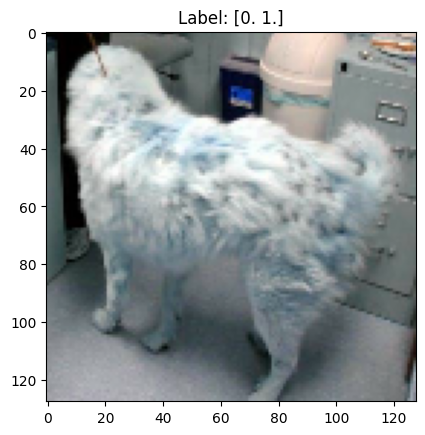

In [9]:
example_image = train_gen[0][0][9]
example_label = train_gen[0][1][9]
print(f"Example image shape: {len(train_gen)}")
#plot image
import matplotlib.pyplot as plt
def plot_image(image, label):
    plt.imshow(image.squeeze())
    plt.title(f"Label: {label}")
    #plt.axis('off')
    plt.show()
   
print(np.max(example_image))
plot_image(example_image, example_label)

# Training

In [ ]:
todaytime = datetime.now()
output_dir = "./training_outputs"
current_tests_folder_name = "train_{}".format(todaytime.strftime("%d-%m-%Y_%H-%M-%S"))
current_output_dir = os.path.join(output_dir, current_tests_folder_name)
if not os.path.exists(current_output_dir):
    os.makedirs(current_output_dir)

initial_learning_rate = 0.001
decay_steps = 1000
keras_optimizer =  tf.keras.optimizers.Adam(
        learning_rate=tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate, decay_steps))
keras_loss = tf.keras.losses.CategoricalCrossentropy()


epochs = 1

notebook_id = generate_notebook_id()
print(f"Notebook ID: {notebook_id}")

custom_cb = ClassificationEvaluationsCallback(
    datagen=test_gen,
    end_of_train_datagen=test_gen,
    every_epoch=3,
    output_file=os.path.join(current_output_dir, "classification_evaluations.txt"),
    class_names=CLASS_NAMES

)

kfold_parameters = {'enable':True, 'split':[0.2, 0.2, 0.2, 0.2, 0.2]}
model_output_name = "tiny_model"

results_dict = training(
        train_gen,
        model=model,
        loss_function=keras_loss,
        optimizer=keras_optimizer,
        epochs=EPOCHS,
        output_dir=current_output_dir,
        validation_split=[0.2, 0.8],
        kfold_param =kfold_parameters,
        model_output_name = model_output_name,
        training_callback=[custom_cb])

Notebook ID: 2025-07-04_10-16-02_cnsr

--- Model training ---


/home/mark/anaconda3/envs/testlib/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - loss: 0.7199 - val_loss: 0.6507
Epoch 2/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - loss: 0.6631 - val_loss: 0.7087
Epoch 3/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.6136


                          METRICS SUMMARY FOR EPOCH 3                           
Best model epoch: 3 | Best loss: 0.6150 | Best val_loss: 0.5807
class_names: ['cats', 'dogs']

--- Evaluate Keras model (instance) ---


Processing data: 100%|██████████| 32/32 [00:07<00:00,  4.09it/s, accuracy=0.486, fn=346, fp=346, tp=654]


Images processed:    32

Per class:
++++++++++++++++++++++++++++++++++++++++++++++++++
Label              | Accuracy  
--------------------------------------------------
cats               | 0.4889    
dogs               | 0.4828    

Overall:
True Positives (TP):      654
False Positives (FP):     346
Overall Accuracy:         0.4859
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 435ms/step - loss: 0.6136 - val_loss: 0.5807



                              METRICS ON TRAIN END                              
class_names: ['cats', 'dogs']

--- Evaluate Keras model (instance) ---


Processing data: 100%|██████████| 32/32 [00:07<00:00,  4.48it/s, accuracy=0.486, fn=346, fp=346, tp=654]


Images processed:    32

Per class:
++++++++++++++++++++++++++++++++++++++++++++++++++
Label              | Accuracy  
--------------------------------------------------
cats               | 0.4889    
dogs               | 0.4828    

Overall:
True Positives (TP):      654
False Positives (FP):     346
Overall Accuracy:         0.4859
Saved trained model at ./training_outputs/train_04-07-2025_10-16-02/saved_models/tiny_model_best.keras 
Converting Keras model './training_outputs/train_04-07-2025_10-16-02/saved_models/tiny_model_best.keras' to ONNX format at './training_outputs/train_04-07-2025_10-16-02/saved_models/tiny_model_best.onnx' with opset 16...


I0000 00:00:1751617013.926664   42478 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1751617013.926829   42478 single_machine.cc:361] Starting new session
I0000 00:00:1751617014.064862   42478 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1751617014.065205   42478 single_machine.cc:361] Starting new session


[2025-07-04 10:16:54] - tf2onnx.tfonnx - INFO - Using tensorflow=2.18.0, onnx=1.17.0, tf2onnx=1.16.1/15c810
[2025-07-04 10:16:54] - tf2onnx.tfonnx - INFO - Using opset <onnx, 16>
[2025-07-04 10:16:54] - tf2onnx.tf_utils - INFO - Computed 0 values for constant folding
[2025-07-04 10:16:54] - tf2onnx.optimizer - INFO - Optimizing ONNX model
[2025-07-04 10:16:54] - tf2onnx.optimizer - INFO - After optimization: Cast -1 (1->0), Identity -2 (2->0), Transpose -6 (8->2)
[2025-07-04 10:16:54] - absl - INFO - Function `function` contains input name(s) resource with unsupported characters which will be renamed to functional_1_dense_1_2_biasadd_readvariableop_resource in the SavedModel.
[2025-07-04 10:16:54] - absl - INFO - Function `function` contains input name(s) resource with unsupported characters which will be renamed to functional_1_dense_1_2_biasadd_readvariableop_resource in the SavedModel.
INFO:tensorflow:Assets written to: /tmp/tmp_e1b50zb/assets
[2025-07-04 10:16:55] - tensorflow - IN

W0000 00:00:1751617015.352429   42478 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1751617015.352462   42478 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-07-04 10:16:55.353070: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp_e1b50zb
2025-07-04 10:16:55.354205: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-07-04 10:16:55.354232: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp_e1b50zb
I0000 00:00:1751617015.363303   42478 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2025-07-04 10:16:55.365370: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-07-04 10:16:55.439172: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp_e1b50zb
2025-07-04 10:16:55.458238: I tensorflow/cc/saved_model/loader.cc:466] SavedModel 

# Inference on test dataset


--- Evaluate Keras model ---


Processing data: 100%|██████████| 32/32 [00:07<00:00,  4.01it/s, accuracy=0.486, fn=346, fp=346, tp=654]


Confusion matrix saved at ./training_outputs/train_04-07-2025_10-16-02/_keras_confusion_matrix.png


<Figure size 1000x700 with 0 Axes>

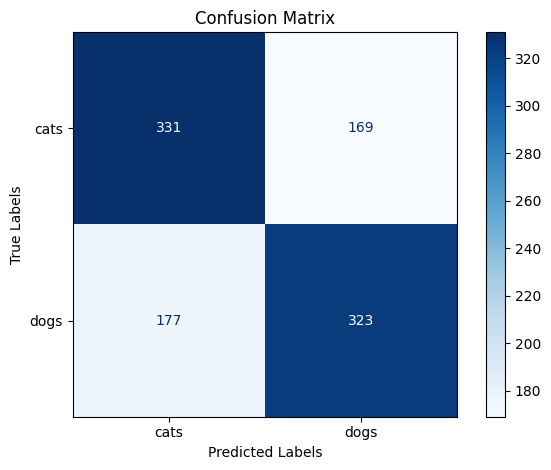

Global metrics:
FP: 346
FN: 346
Accuracy: 0.4859

Per-class metrics:
Class: cats
  FP: 177
  FN: 169
  Accuracy: 0.4889
Class: dogs
  FP: 169
  FN: 177
  Accuracy: 0.4828


In [11]:
if kfold_parameters['enable']:
    model_path = os.path.join(current_output_dir, "golden_model_folder", "golden_model.keras")
else:
    model_path = os.path.join(current_output_dir, "saved_models", f"{model_output_name}_best.keras")

global_metric, metric_per_class = evaluate_model(
    model_path, 
    test_gen=test_gen,
    output_dir=current_output_dir,
    conf_matrix=True
)
print("Global metrics:")
print("FP:", global_metric.getFP())
print("FN:", global_metric.getFN())
print("Accuracy:", f"{global_metric.getAccuracy():.4f}")

print("\nPer-class metrics:")
for idx, class_name in enumerate(CLASS_NAMES):
    print(f"Class: {class_name}")
    print("  FP:", metric_per_class[idx].getFP())
    print("  FN:", metric_per_class[idx].getFN())
    print("  Accuracy:", f"{metric_per_class[idx].getAccuracy():.4f}")

INFO:tensorflow:Assets written to: /tmp/tmpi2e1uqun/assets
[2025-07-04 10:17:05] - tensorflow - INFO - Assets written to: /tmp/tmpi2e1uqun/assets
Saved artifact at '/tmp/tmpi2e1uqun'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  132763084319104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132758762882848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132763287743376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132761880316032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132761866389984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132763285734320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132763285733792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132763285739776: TensorSpec(shape=(), dtype=tf.resource, name=None)


/home/mark/anaconda3/envs/testlib/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1751617025.660742   42478 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1751617025.660781   42478 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-07-04 10:17:05.661368: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpi2e1uqun
2025-07-04 10:17:05.662574: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-07-04 10:17:05.662598: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpi2e1uqun
2025-07-04 10:17:05.672484: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-07-04 10:17:05.747872: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path

Quantized model saved at ./training_outputs/train_04-07-2025_10-16-02/saved_models/quantize/tiny_model_quantized.tflite

--- Evaluate TFLite model ---


Processing data:   3%|▎         | 1/32 [00:00<00:03,  8.98it/s, accuracy=0.488, fn=11, fp=11, tp=21]

Resizing input tensor to: (32, 128, 128, 3)


Processing data: 100%|██████████| 32/32 [00:03<00:00,  9.45it/s, accuracy=0.489, fn=343, fp=343, tp=657]


Resizing input tensor to: (8, 128, 128, 3)
Confusion matrix saved at ./training_outputs/train_04-07-2025_10-16-02/_tflite_confusion_matrix.png


<Figure size 1000x700 with 0 Axes>

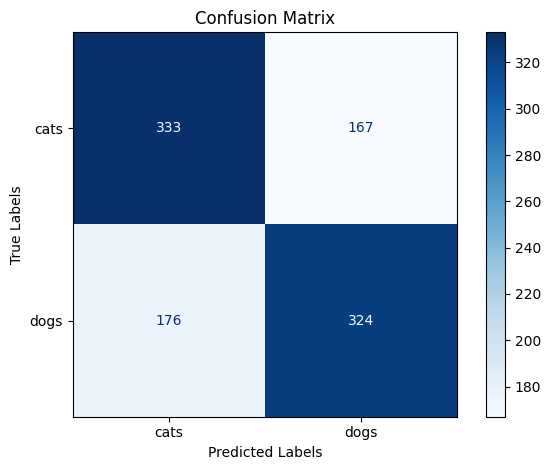

Global metrics:
FP: 343
FN: 343
Accuracy: 0.4892

Per-class metrics:
Class: cats
  FP: 176
  FN: 167
  Accuracy: 0.4926
Class: dogs
  FP: 167
  FN: 176
  Accuracy: 0.4858


In [12]:
from saltup.ai.utils.keras.quantization import quantize

if kfold_parameters['enable']:
    model_path = os.path.join(current_output_dir, "golden_model_folder", "golden_model.keras")
    quantized_model_path = os.path.join(current_output_dir, "golden_model_folder", "quantize", "golden_model_quantized.tflite")
else:
    model_path = os.path.join(current_output_dir, "saved_models", f"{model_output_name}_best.keras")
    quantized_model_path = os.path.join(current_output_dir, "saved_models", "quantize", f"{model_output_name}_quantized.tflite")

def representative_data_gen_fnct(datagenerator):
    for i in range(len(datagenerator)):
        images, _ = datagenerator[i]
        # If batch, yield each image separately for calibration
        if images.ndim == 4:
            for img in images:
                yield [img.astype(np.float32).reshape(1, *img.shape)]
        else:
            yield [images.astype(np.float32).reshape(1, *images.shape)]

# Pass the generator function itself, not its call
representative_data_gen = lambda: representative_data_gen_fnct(train_gen)
        

quantized_model_path = quantize(model_path, quantized_model_path, 
                           representative_data_gen, 
                           input_type = tf.uint8, 
                           output_type = tf.uint8)

global_metric, metric_per_class = evaluate_model(
    quantized_model_path, 
    test_gen=test_gen,
    output_dir=current_output_dir,
    conf_matrix=True
)
print("Global metrics:")
print("FP:", global_metric.getFP())
print("FN:", global_metric.getFN())
print("Accuracy:", f"{global_metric.getAccuracy():.4f}")

print("\nPer-class metrics:")
for idx, class_name in enumerate(CLASS_NAMES):
    print(f"Class: {class_name}")
    print("  FP:", metric_per_class[idx].getFP())
    print("  FN:", metric_per_class[idx].getFN())
    print("  Accuracy:", f"{metric_per_class[idx].getAccuracy():.4f}")